In [223]:
# Import
import pandas as pd
import numpy as np
from lxml import etree
from utils.progress_bar import progress
from utils.statistics import statistics, bar_chart_simple
import matplotlib

# Matplotlib confs
%matplotlib inline
matplotlib.style.use("seaborn")

# Constraints
APPALTI_XSD = "http://dati.anticorruzione.it/schema/datasetAppaltiL190.xsd"
INDICE_APPALTI_XSD = "http://dati.anticorruzione.it/schema/datasetIndiceAppaltiL190.xsd"

#TEST_APPALTI="http://www.archiviodistatotrento.beniculturali.it/MW/mediaArchive/Archive/avcp_dataset_2014.xml"
#TEST_INDICE="http://www.studiok.it/COMUNI/RONCOBELLO/AVCP/datasetIndiceAppalti.xml"

In [224]:
df = pd.read_csv('data/l190-collected.csv', sep=';')
#df.head()

In [225]:
df = df.loc[:,('esitoUltimoTentativoAccessoUrl','url', 'anno', 'ext')].copy()
df['anno']= df['anno'].astype('object')

df_suc=df.loc[(df["esitoUltimoTentativoAccessoUrl"] =='successo')].copy()


## Controllo sintattico 
Pur avendo esito della comunicazione positivo, alcuni url non sono formattati correttamente. Di seguito si procede al controllo sintattico riguardante gli spazi e successivamente alla corretta formattazione dell'url.

### Controllo sugli spazi
Gli elementi contenete spazi nell'attributo url sono:

In [226]:
# Controlla url con spazi
df_suc_with_blank_in_url= df_suc[df_suc['url'].str.contains(" ", na=np.nan)==True].copy()
df_suc_with_blank_in_url.shape[0]

2298

In [227]:
# Applica eliminazione spazi
df_suc['url']=df_suc['url'].apply(lambda x: x.strip('\n').strip(' ').replace(" ", "").replace("\t", ""))

# Controlla url con spazi
df_suc_with_blank_in_url= df_suc[df_suc['url'].str.contains(" ", na=np.nan)==True].copy()
df_suc_with_blank_in_url.shape[0]

0

### Controllo sintassi url nella forma corretta forma
Gli elmenti url che on conminciano con http:// or https:// sono:

In [228]:
df_suc_with_wrong_start=df_suc[df_suc['url'].str.match('http|HTTP(s|S)?\:\/\/*')==False].copy()
df_suc_with_wrong_start.shape[0]

583

In [237]:
# Trova tutti quelli elementi che non soddisfano la condizione http|HTTP(s|S)?\:\/\/* e inserisci prima http://
df_suc['url']=df_suc.loc[df_suc['url'].str.match('http|HTTP(s|S)?\:\/\/*')==False, ('url')].apply(lambda x: "http://"+x)

# Ricontrollo elementi che non cominciano con http:// or https:// 
df_suc_with_wrong_start=df_suc[df_suc['url'].str.match('http|HTTP(s|S)?\:\/\/*')==False].copy()
df_suc_with_wrong_start.shape[0]

0

In [108]:
# Ricavare lo schema degli appalti
appalti_xmlschema_doc = etree.parse(APPALTI_XSD)
appalti_xmlschema = etree.XMLSchema(appalti_xmlschema_doc)
# Ricavare lo schema degli indice appalti
indice_xmlschema_doc = etree.parse(INDICE_APPALTI_XSD)
indice_xmlschema = etree.XMLSchema(indice_xmlschema_doc)

# UnComment for test
df_suc=df_suc.loc[:100, :].copy()
   
# Per ogni url avvenuto con successo
def validate_schema(row,total):
    
    print ("[",row.name,"/", total,"]: ",row.url)
    # Prova a scaricare l'xml se va in errore passa avanti
    try:
        doc = etree.parse(row.url)
        # Validare 
        if appalti_xmlschema.validate(doc):
        # Se la validazione è andata a buon fine con appalti aggiungi colonna appalti
            result ="Appalti"
        # Se la validazione è andata a buon fine con indice aggiungi colonna df indice
        elif indice_xmlschema.validate(doc):
            result ="Indice Appalti"
        # Altrimenti xml non valido
        else:
            result =np.NaN
    except (OSError, etree.XMLSyntaxError) as e:
        result= type(e).__name__
    return result

df_suc['XMLSchema'] = df_suc.apply(validate_schema,args=(df_suc.index[-1],), axis=1) 


[ 2 / 100 ]:  http://omnicomprensivocerretodispoleto.it/avcp/trasparenza/11/2014.xml
[ 3 / 100 ]:  http://www.consorzioinviolatellasalaria.it/AVCP/2014/dataset2.xml
[ 6 / 100 ]:  http://www.icsanmartinovc.gov.it/amministrazione-trasparente/bandi-di-concorso/informazioni-di-cui-alla-deliberazione-avcp-n26-del-22052013/item/download/211
[ 9 / 100 ]:  http://www.comune.buccinasco.mi.it/openweb/web/benefici/appalti/pubblicazione_legge190_2014.xml
[ 10 / 100 ]:  http://www.studiok.it/COMUNI/RONCOBELLO/AVCP/datasetIndiceAppalti.xml
[ 13 / 100 ]:  http://www.archiviodistatotrento.beniculturali.it/MW/mediaArchive/Archive/avcp_dataset_2014.xml
[ 14 / 100 ]:  http://www.archeologicamolise.beniculturali.it/getFile.php?id=1311
[ 15 / 100 ]:  http://hosting.soluzionipa.it/orco_feglino/benefici/appalti/pubblicazione_legge190_2014.xml
[ 16 / 100 ]:  http://www.comuneardauli.gov.it/docs/avcp/dataset_2014.xml
[ 19 / 100 ]:  http://www.iccologne.gov.it/sites/default/files/articoli/2014-2015-cig.2014.xml

In [122]:
df_suc

,esitoUltimoTentativoAccessoUrl,url,anno,ext,XMLSchema
2,successo,http://omnicomprensivocerretodispoleto.it/avcp...,2015,xml,OSError
3,successo,http://www.consorzioinviolatellasalaria.it/AVC...,2015,xml,Appalti
6,successo,http://www.icsanmartinovc.gov.it/amministrazio...,2015,altro,OSError
9,successo,http://www.comune.buccinasco.mi.it/openweb/web...,2015,xml,OSError
10,successo,http://www.studiok.it/COMUNI/RONCOBELLO/AVCP/d...,2015,xml,Indice Appalti
13,successo,http://www.archiviodistatotrento.beniculturali...,2015,xml,Appalti
14,successo,http://www.archeologicamolise.beniculturali.it...,2015,altro,Appalti
15,successo,http://hosting.soluzionipa.it/orco_feglino/ben...,2015,xml,Appalti
16,successo,http://www.comuneardauli.gov.it/docs/avcp/data...,2015,xml,Appalti
19,successo,http://www.iccologne.gov.it/sites/default/file...,2015,xml,OSError


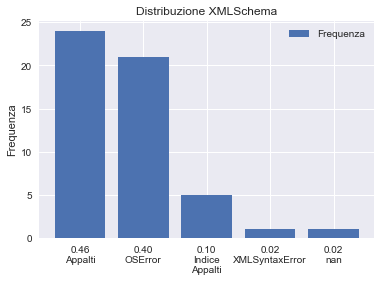

In [127]:
df_stats= statistics(df_suc[['XMLSchema']])
for field in df_stats['Fields']:
    col = df_suc[field].value_counts(dropna=False)
    titolo = "Distribuzione "+str(field)
    bar_chart_simple(col, titolo)

In [42]:
def serialize_field(node, field):
    result = ','.join(y.text for y in node.find_all(field))
    result = np.nan if len(result)==0 else result
    return result

In [6]:
def get_field(node, field):
    try:
        result = node.find(field).text
    except AttributeError:
        result = np.nan

    return result

In [26]:
from bs4 import BeautifulSoup
import urllib

In [42]:
def xml_parse(url, df):
    
    try:
        with urllib.request.urlopen(url) as response:
            xml = response.read()

    except (urllib.error.URLError, urllib.error.HTTPError) as e:
        print (e)
        print (e.args)
        return df
    
    
    #xml = open('data/test1.xml')
    soup = BeautifulSoup(xml, "lxml")
    
    lotti = soup.find_all("lotto")
    for i in range (0, len(lotti)):
        x = lotti[i]

        cig = get_field(x,"cig")
        codicefiscale_prop = x.find("strutturaproponente").find('codicefiscaleprop').text
        denominazione = x.find('strutturaproponente').find('denominazione').text
        oggetto = x.find('oggetto').text
        scelta_contraente = x.find('sceltacontraente').text
        partecipanti = serialize_field(x.partecipanti, "codicefiscale")
        aggiudicatari = serialize_field(x.aggiudicatari, "codicefiscale")
        importo_aggiudicazione = x.find('importoaggiudicazione').text
        data_inizio = get_field(x.tempicompletamento,"datainizio")
        data_fine = get_field(x.tempicompletamento,"dataultimazione")
        importo_somme_liquidate = x.find('importosommeliquidate').text
    
    
        df = df.append(
            pd.Series([cig, codicefiscale_prop, denominazione,
                       oggetto, scelta_contraente, partecipanti,
                       aggiudicatari, importo_aggiudicazione, data_inizio,
                       data_fine, importo_somme_liquidate
                      ], index=list(df_xml.columns)),
            ignore_index=True)
    return df

In [43]:
df_xml = pd.DataFrame({'cig':[], 
                   'codicefiscale_prop': [],
                   'denominazione': [],
                   'oggetto': [],
                   'scelta_contraente': [],
                   'partecipanti': [],
                   'aggiudicatari': [],
                   'importo_aggiudicazione': [],
                   'data_inizio': [],
                   'data_fine': [],    
                   'importo_somme_liquidate': [],
                  })
df_xml = df_xml[['cig', 
                 'codicefiscale_prop', 
                 'denominazione', 
                 'oggetto',
                 'scelta_contraente',
                 'partecipanti',
                 'aggiudicatari',
                 'importo_aggiudicazione',
                 'data_inizio',
                 'data_fine',
                 'importo_somme_liquidate',
                ]]
    
df = df.loc[:20, ['url']]
for row in df.itertuples():
    df_xml = xml_parse(row.url,df_xml)    
    print (row.url)

<urlopen error [Errno 8] nodename nor servname provided, or not known>
(gaierror(8, 'nodename nor servname provided, or not known'),)
http://omnicomprensivocerretodispoleto.it/avcp/trasparenza/11/2014.xml
http://www.consorzioinviolatellasalaria.it/AVCP/2014/dataset2.xml
HTTP Error 404: Not Found
()
http://www.icsanmartinovc.gov.it/amministrazione-trasparente/bandi-di-concorso/informazioni-di-cui-alla-deliberazione-avcp-n26-del-22052013/item/download/211
HTTP Error 404: Not Found
()
http://www.comune.buccinasco.mi.it/openweb/web/benefici/appalti/pubblicazione_legge190_2014.xml
http://www.studiok.it/COMUNI/RONCOBELLO/AVCP/datasetIndiceAppalti.xml
http://www.archiviodistatotrento.beniculturali.it/MW/mediaArchive/Archive/avcp_dataset_2014.xml
http://www.archeologicamolise.beniculturali.it/getFile.php?id=1311
http://hosting.soluzionipa.it/orco_feglino/benefici/appalti/pubblicazione_legge190_2014.xml
http://www.comuneardauli.gov.it/docs/avcp/dataset_2014.xml
HTTP Error 404: Not Found
()
http

In [35]:
df

,url
2,http://omnicomprensivocerretodispoleto.it/avcp...
3,http://www.consorzioinviolatellasalaria.it/AVC...
6,http://www.icsanmartinovc.gov.it/amministrazio...
9,http://www.comune.buccinasco.mi.it/openweb/web...
10,http://www.studiok.it/COMUNI/RONCOBELLO/AVCP/d...
13,http://www.archiviodistatotrento.beniculturali...
14,http://www.archeologicamolise.beniculturali.it...
15,http://hosting.soluzionipa.it/orco_feglino/ben...
16,http://www.comuneardauli.gov.it/docs/avcp/data...
19,http://www.iccologne.gov.it/sites/default/file...


In [35]:
df_xml.to_csv('data/xml-collected.csv', sep=';')

In [36]:
df_xml[df_xml['partecipanti'].str.contains(",", na=np.nan)==True]

,cig,codicefiscale_prop,denominazione,oggetto,scelta_contraente,partecipanti,aggiudicatari,importo_aggiudicazione,data_inizio,data_fine,importo_somme_liquidate
36,62146256C8,00100630573,UFFICIO AMMINISTRATIVO,FORNITURA MATERIALE DI CANCELLERIA PER UFFICI ...,23-AFFIDAMENTO IN ECONOMIA - AFFIDAMENTO DIRETTO,"01006250573,03222970406,00947770574",NaN,4000.00,2015-03-23,2015-12-31,0
48,,00100630573,UFFICIO AMMINISTRATIVO,CONCESSIONE SOVVENZIONI E CONTRIBUTI - IMPEGNO...,23-AFFIDAMENTO IN ECONOMIA - AFFIDAMENTO DIRETTO,"00011650570,90033690570,00904460573","00011650570,90033690570,00904460573",13350.00,2015-07-10,NaN,0
49,,00100630573,UFFICIO AMMINISTRATIVO,LIQUIDAZIONE CONTRIBUTI,23-AFFIDAMENTO IN ECONOMIA - AFFIDAMENTO DIRETTO,"00904460573,90011665057,90033690570","00904460573,90011665057,90033690570",0,2015-07-16,2015-07-16,6275.00
94,653337037B,00100630573,UFFICIO AMMINISTRATIVO,PACCHI DONO AGLI ANZIANI E AGLI HANDICAPPATI I...,23-AFFIDAMENTO IN ECONOMIA - AFFIDAMENTO DIRETTO,"00920670577,01118510575","00920670577,01118510575",2100.00,2015-12-05,NaN,0
97,62146256C8,00100630573,UFFICIO AMMINISTRATIVO,FORNITURA MATERIALEDI CANCELLERIA - INTEGRAZIO...,23-AFFIDAMENTO IN ECONOMIA - AFFIDAMENTO DIRETTO,"01006250573,03222970406,00947770574",NaN,1360.00,2015-12-15,NaN,0
98,6533301A88,00100630573,UFFICIO AMMINISTRATIVO,ACQUISIZIONE MATERIALE VARIO PER UFFICIO TURIS...,23-AFFIDAMENTO IN ECONOMIA - AFFIDAMENTO DIRETTO,"00622910578,01034870574","00622910578,01034870574",871.06,2015-12-15,NaN,0


XMLSyntaxError: Element 'a': 'no int' is not a valid value of the atomic type 'xs:integer'. (<string>, line 0)